In [1]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from keybert import KeyBERT
import yake
import string
import numpy as np
import datetime

In [2]:
sds_data = pd.read_csv('../data/sds_ds_text.csv')
#sds_non_data = pd.read_csv('../data/sds_nds_text.csv')

<IPython.core.display.Javascript object>

In [ ]:
sds_data['episode_split_text'].loc[400]

In [ ]:
# Function to clean the text 
def lower_text(text):  
    # Lowercase the text
    if isinstance(text, float):
        return text
    text = text.lower()
    # Remove punctuation from the text
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove digits from the text
    text = ''.join(char for char in text if not char.isdigit())
    return text

In [ ]:
sds_data['episode_split_text'] = sds_data['episode_split_text'].apply(lower_text)

In [ ]:
sds_data.to_csv('../data/sds_BERTopic_split.csv')

## Generating keywords for Data Science Episodes

In [3]:
sds_ds_processed = pd.DataFrame(sds_data.groupby(['episode_number', 'episode_name', 'length_episode', 'class', 'guest_name', 'host_episode', 'episode_year', 'episode_date'])['episode_split_text'].agg(lambda x: ' '.join(str(i) for i in x))).reset_index()

<IPython.core.display.Javascript object>

In [ ]:
sds_ds_processed

In [ ]:
#sds_ds_combined

In [ ]:
# Remove episode 202 and 546 with no text in episode_split_text
#sds_processed = 
#sds_ds_processed[sds_ds_processed['episode_split_text'] == 'nan']#.reset_index(drop = True)

In [4]:
# Function to clean the text 
def processed_text(text):  
    # Lowercase the text
    text = text.lower()
    # Remove punctuation from the text
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove digits from the text
    text = ''.join(char for char in text if not char.isdigit())
    return text

In [ ]:
sds_ds_processed['episode_split_text'].loc[1]

In [5]:
sds_ds_processed['episode_split_text'] = sds_ds_processed['episode_split_text'].apply(processed_text)

In [ ]:
sds_ds_processed

In [ ]:
sds_ds_processed

In [ ]:
sds_ds_processed.info()

In [ ]:
sds_ds_processed['episode_split_text'].loc[400]

In [ ]:
sds_ds_processed['episode_keywords_1_2'] = None

In [6]:
sds_ds_processed['episode_keywords_1_3'] = None

In [ ]:
sds_ds_processed

In [7]:
# Function to generate 100 keywords per episode using Yake library to store keywords in one column as list
def yake_keyword_extractor(doc):
    global sds_ds_processed
    
    for i, episode_text in doc.iteritems():
        max_ngram_size = 3
        deduplication_threshold = 0.3
        windowSize = 1
        numOfKeywords = 100
        kw_extractor = yake.KeywordExtractor(n = max_ngram_size, dedupLim = deduplication_threshold , windowsSize = windowSize, top = numOfKeywords)
        keywords = kw_extractor.extract_keywords(episode_text)
        sds_ds_processed.at[i, 'episode_keywords_1_3'] = keywords

In [8]:
yake_keyword_extractor(sds_ds_processed['episode_split_text'])

In [ ]:
sds_ds_processed

In [9]:
def tuple_extractor(row):
    words = [t[0].replace(" ", "_") for t in row]
    return " ".join(words)

In [10]:
sds_ds_processed['keywords1_3'] = sds_ds_processed['episode_keywords_1_3'].apply(tuple_extractor)

In [11]:
sds_ds_processed.to_csv('../data/keywords1_3_9June.csv', index = False)

In [ ]:
sds_ds_processed['keywords'] = sds_ds_processed['episode_keywords'].apply(tuple_extractor)

In [ ]:
sds_ds_processed

In [ ]:
sds_ds_processed.to_csv('../data/sds_ds_keywords.csv', index = False)

## Generating keywords for non-Data Science Episodes

In [ ]:
sds_nds_processed = pd.DataFrame(sds_non_data.groupby(['episode_number', 'episode_name', 'length_episode', 'context_episode', 'guest_name', 'host_episode', 'episode_year'])['episode_split_text'].agg(lambda x: ' '.join(str(i) for i in x))).reset_index()

In [ ]:
sds_nds_processed['episode_split_text'] = sds_nds_processed['episode_split_text'].apply(processed_text)

In [ ]:
sds_nds_processed['episode_keywords'] = None

In [ ]:
# Function to generate 100 keywords per episode using Yake library to store keywords in one column as list
def yake_keyword_extractor(doc):
    global sds_nds_processed
    
    for i, episode_text in doc.iteritems():
        max_ngram_size = 3
        deduplication_threshold = 0.3
        windowSize = 1
        numOfKeywords = 100
        kw_extractor = yake.KeywordExtractor(n = max_ngram_size, dedupLim = deduplication_threshold , windowsSize = windowSize, top = numOfKeywords)
        keywords = kw_extractor.extract_keywords(episode_text)
        sds_nds_processed.at[i, 'episode_keywords'] = keywords

In [ ]:
yake_keyword_extractor(sds_nds_processed['episode_split_text'])

In [ ]:
sds_nds_processed['keywords'] = sds_nds_processed['episode_keywords'].apply(tuple_extractor)

In [ ]:
sds_nds_processed

In [ ]:
sds_nds_processed.to_csv('../data/sds_nds_keywords.csv', index = False)

### Count Vectorizer and Class-Based Tfidf

In [12]:
import scipy.sparse as sp
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.preprocessing import normalize

In [48]:
sds_ds_keywords1_3 = pd.read_csv('../data/keywords1_3_9June.csv')

keywords_per_class1_3 = sds_ds_keywords1_3.groupby('class')['keywords1_3'].apply(' '.join).reset_index()

# Rename the columns to match the original code
keywords_per_class1_3 = keywords_per_class1_3.rename(columns={'class': 'Class', 'keywords1_3': 'Document'})

<IPython.core.display.Javascript object>

In [49]:
keywords_per_class1_3

,Class,Document
0,Artificial Intelligence,data_science_work governments_data_science sci...
1,"Artificial Intelligence, Deep Learning",kaggle_competitions_basically people_basically...
2,Blockchain,basically_apply_blockchain blockchain_intermed...
3,Data Science,data_scientist_role suppose_data_science busin...
4,"Data Science, Career",data_science_interview super_data_science sql_...
5,"Data Science, Productivity",machine_learning_basically data_science_machin...
6,Data Visualization,learning_data_science data_science_journey dat...
7,Database,data_science elemental_data_problems science_s...
8,Deep Learning,machine_learning_models data_science_machine l...
9,Machine Learning,machine_learning_machine data_data_science lea...


In [ ]:
keywords_per_class['Document'].loc[0]

In [ ]:
sds_ds_keywords = pd.read_csv('../data/sds_ds_keywords.csv')

keywords_per_class = sds_ds_keywords.groupby('class')['keywords'].apply(' '.join).reset_index()

# Rename the columns to match the original code
keywords_per_class = keywords_per_class.rename(columns={'class': 'Class', 'keywords': 'Document'})

In [ ]:
keywords_per_class

In [ ]:
keywords_per_class

In [50]:
class CTFIDFVectorizer(TfidfTransformer):
    def __init__(self, *args, **kwargs):
        super(CTFIDFVectorizer, self).__init__(*args, **kwargs)

    def fit(self, X: sp.csr_matrix, n_samples: int):
        """Learn the idf vector (global term weights) """
        _, n_features = X.shape
        df = np.squeeze(np.asarray(X.sum(axis=0)))
        idf = np.log(n_samples / df)
        self._idf_diag = sp.diags(idf, offsets=0,
                                  shape=(n_features, n_features),
                                  format='csr',
                                  dtype=np.float64)
        return self

    def transform(self, X: sp.csr_matrix) -> sp.csr_matrix:
        """Transform a count-based matrix to c-TF-IDF """
        X = X * self._idf_diag
        X = normalize(X, axis=1, norm='l1', copy=False)
        return X

In [51]:
# Create c-TF-IDF
count = CountVectorizer().fit_transform(keywords_per_class1_3.Document)
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(keywords_per_class1_3)).toarray()

In [52]:
# Create bag of words using count vectorizer
count_vectorizer = CountVectorizer().fit(keywords_per_class1_3.Document)
count = count_vectorizer.transform(keywords_per_class1_3.Document)
words = count_vectorizer.get_feature_names_out()

In [53]:
count_vectorizer.vocabulary_

{'data_science_work': 6475,
 'governments_data_science': 11426,
 'science_data_collection': 23598,
 'work_programmers_data': 30029,
 'podcast_today_ive': 20484,
 'left_brain_people': 15804,
 'people_indecipherable_things': 19827,
 'unsupervised_learning_works': 28907,
 'taxpayers_money_governments': 26806,
 'main_things_today': 16735,
 'data_analytics_capabilitiesand': 6245,
 'time_dont_read': 27681,
 'departments_performing_business': 6938,
 'ive_read_bits': 14529,
 'arts_youve_studied': 1519,
 'thing_called_stem': 27389,
 'university_studies_interesting': 28857,
 'data': 6230,
 'youve_grown_youve': 30667,
 'year_time_chain': 30396,
 'good_bacteria_probiotic': 11124,
 'yay_good_finally': 30363,
 'photography_sculpture_painting': 20199,
 'latest_technology_implement': 15528,
 'pure_technical_background': 21753,
 'called_steam_steam': 3868,
 'lot': 16335,
 'huge_competitive_edgeon': 12889,
 'inanimate_objects_anymore': 13490,
 'work': 29978,
 'subject_matter_experts': 26113,
 'high_low_

In [54]:
len(count_vectorizer.vocabulary_)

30774

In [31]:
count.shape

(15, 22603)

In [55]:
word_counts = pd.DataFrame({
    'words': count_vectorizer.get_feature_names_out(),
    'frequency': np.array(count.sum(axis = 0)).flatten()
})
word_counts.sort_values('frequency', ascending = False)

<IPython.core.display.Javascript object>

,words,frequency
6230,data,363
16335,lot,268
24222,show,192
29978,work,182
16785,make,180
...,...,...
10672,gabriels,1
10671,gabriela_today,1
10670,gabriela_regularly_presents,1
10669,gabriela,1


In [ ]:
word_counts[word_counts['frequency'] < 5]

In [56]:
# class based tfidf
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(keywords_per_class1_3)).toarray()

In [57]:
# find top words in each class
top_words_per_class = []
for i, class_docs in enumerate(keywords_per_class1_3.Document):
    tfidf_scores = ctfidf[i]
    top_word_indices = np.argsort(tfidf_scores)[:20]  # index
    top_words = [words[idx] for idx in top_word_indices]  # feature name
    top_words_per_class.append(top_words)

class_most_common_20 = pd.DataFrame({'Class': keywords_per_class.Class, 'top_Words': top_words_per_class})

<IPython.core.display.Javascript object>

In [36]:
class_most_common_20

,Class,top_Words
0,Artificial Intelligence,"[lot, artificial_intelligence, machine_learnin..."
1,"Artificial Intelligence, Deep Learning","[artificial_intelligence, successful_career, s..."
2,Blockchain,"[data_science, make, talk, lot, show, day, ide..."
3,Data Science,"[data_science, lot, show, make, time, people, ..."
4,"Data Science, Career","[kind, lot, time, make, data_science, people, ..."
5,"Data Science, Productivity","[day, find, make, machine_learning, time, epis..."
6,Data Visualization,"[data_science, lot, make, people, show, succes..."
7,Database,"[data_science, lot, show, people, talk, day, w..."
8,Deep Learning,"[data_science, make, show, time, work, kind, b..."
9,Machine Learning,"[data_science, lot, machine_learning, make, sh..."


In [ ]:
class_most_common_20['top_Words'].loc[0]

In [58]:
# find unique words in each class
unique_words_per_class = []
for i, class_docs in enumerate(keywords_per_class1_3.Document):
    tfidf_scores = ctfidf[i]
    unique_word_indices = np.argsort(tfidf_scores)[-100:][::-1]  # index
    unique_words = [words[idx] for idx in unique_word_indices]  # feature name
    unique_words_per_class.append(unique_words)

class_unique_100 = pd.DataFrame({'Class': keywords_per_class1_3.Class, 'unique_Words': unique_words_per_class})


<IPython.core.display.Javascript object>

In [68]:
class_unique_100

,Class,unique_Words
0,Artificial Intelligence,"[meta, universities_provide_access, bert, arti..."
1,"Artificial Intelligence, Deep Learning","[environment, atari_video_games, deep_learning..."
2,Blockchain,"[unique_path_checking, cliff, fail_quickly_sta..."
3,Data Science,"[friday_episode_number, wrong, minutes, post, ..."
4,"Data Science, Career","[aws, cole_nussbaumer_knaflic, facilitates_tea..."
5,"Data Science, Productivity","[lot_of_control, study_hours, adobe_suite, win..."
6,Data Visualization,"[qlik, kate_strachnyi_data, chart, data_scienc..."
7,Database,"[normal_forms, ruben, microsoft_sql_server, wa..."
8,Deep Learning,"[dry_stupidest_book, vision_problems_manufactu..."
9,Machine Learning,"[powerful_rust_engine, directed_acyclic_graph,..."


In [72]:
class_unique_100['unique_Words'].loc[6]

['qlik',
 'kate_strachnyi_data',
 'chart',
 'data_science_books',
 'elementary_perceptual_tasks',
 'support_rep',
 'people_care_people',
 'nussbaumer_knaflic',
 'axis',
 'eva',
 'todays_episode_kate',
 'andy',
 'technique',
 'bit_back',
 'alteryx',
 'red',
 'audience',
 'wall_street_journal',
 'vis_wow_congrats',
 'visa_mastercard_american',
 'challenging_thing',
 'good_hour',
 'good_great',
 'incredibly_important_skill',
 'limited_budget',
 'change_people_vote',
 'nights_and_weekends',
 'good_functionality',
 'change_the_trajectory',
 'night',
 'incredibly_silly_questions',
 'nights_sleeps',
 'nights_weekends',
 'good_day_traffic',
 'vision_mission_statements',
 'chap_called',
 'approach_things_differently',
 'approach_the_audience',
 'approach_tailored',
 'good_day_bye',
 'good_job_absolutely',
 'quickly_answer_business',
 'nice_restaurant_called',
 'nice_nice_nice',
 'super_powerful_aspect',
 'case_study_practice',
 'linear_regression_support',
 'super_fast_super',
 'super_exciting_

In [ ]:
class_unique_100['unique_Words'].loc[0]

In [ ]:
class_unique_50['Class'].unique()

In [ ]:
class_unique_50.to_csv('../data/keywords_u20.csv')

### Generate word cloud

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

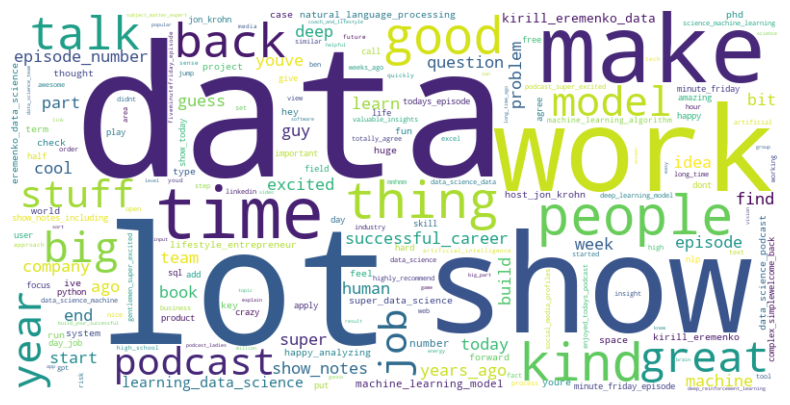

In [60]:

all_keywords = ' '.join(keywords_per_class1_3.Document)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

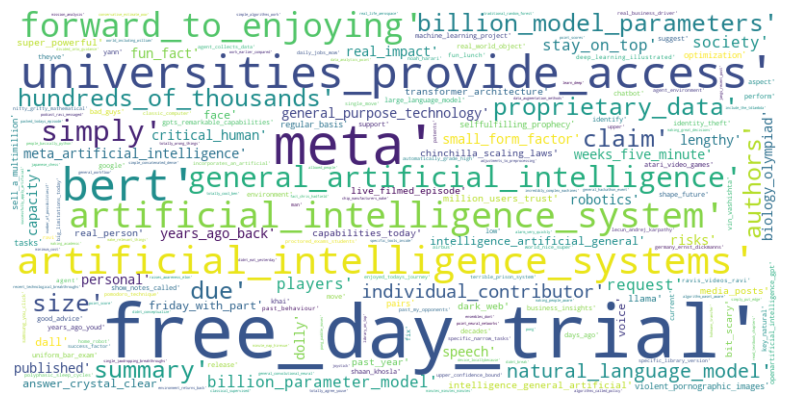

In [62]:
all_keywords = ' '.join(map(str, class_unique_100.unique_Words))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
sds_ds_bert = pd.read_csv('../data/sds_ds_keywords.csv')

In [ ]:
sds_ds_bert["episode_keywords"] = None
sds_ds_bert["keywords"] = None

In [ ]:
sds_ds_bert

In [ ]:
def bert_keyword_extractor(doc):
    kw_model = KeyBERT()
    global sds_ds_bert
    stopwords = list(STOP_WORDS)
    
    for i, episode_text in doc.iteritems():
        keywords = kw_model.extract_keywords(episode_text, keyphrase_ngram_range=(1, 3), stop_words = stopwords, top_n = 100, use_mmr=True, diversity=0.7)
        sds_ds_bert.at[i, 'episode_keywords'] = keywords

In [ ]:
bert_keyword_extractor(sds_ds_bert['episode_split_text'])

In [ ]:
sds_ds_bert['episode_keywords'].loc[0]

In [ ]:
# https://maartengr.github.io/BERTopic/index.html